In [1]:
from typing import List, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import torchinfo

torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create dataset

In [2]:
def create_dataloader(dataset, transform=None, val_split=0.25, batch_size=64, num_workers=2):
    train_set = dataset('../data', train=True,  download=True, transform=transform)
    test_set  = dataset('../data', train=False, download=True, transform=transform)
    
    train_set, val_set = torch.utils.data.random_split(train_set, [1-val_split, val_split])
    
    train = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True,  num_workers=num_workers)
    val   = torch.utils.data.DataLoader(val_set,   batch_size=batch_size, shuffle=True,  num_workers=num_workers)
    test  = torch.utils.data.DataLoader(test_set,  batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return (train, val, test)

# Create model

## Gradient Reversal Layer

In [3]:
class ReverseLayerF(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)
    
    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha
        return output, None

# Create model

## CNN

In [4]:
class FeatureExtractor(nn.Module):
    def __init__(self, input_shape: Tuple[int], cnn_out_features: List[int]):
        super().__init__()
        
        self.cnn_layers = nn.ModuleList()
        shape = list(input_shape)
        prev_nf = input_shape[0]
        
        for curr_nf in cnn_out_features:
            self.cnn_layers.append(nn.Sequential(
                nn.Conv2d(prev_nf, curr_nf, kernel_size=3, padding='same'),
                nn.MaxPool2d(2)
            ))
            prev_nf = curr_nf
            
            shape[0] = curr_nf
            shape[1] = int(shape[1] / 2)
            shape[2] = int(shape[2] / 2)
        
        self.input_shape = input_shape
        self.output_shape = (shape[0], shape[1], shape[2])
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for layer in self.cnn_layers:
            x = layer(x)
        return x

In [5]:
class ClassRegressor(nn.Module):
    def __init__(self, input_shape: Tuple[int], output_shape: int, fnn_out_features: List[int]):
        super().__init__()
        
        if isinstance(input_shape, tuple):
            in_features = 1
            for x in input_shape:
                in_features *= x
        else:
            in_features = input_shape
        
        self.fnn_layers = nn.ModuleList()
        prev_nf = in_features
        
        for curr_nf in fnn_out_features:
            self.fnn_layers.append(nn.Sequential(
                nn.Linear(prev_nf, curr_nf),
                nn.ReLU()
            ))
            prev_nf = curr_nf
        
        self.op_layer = nn.Linear(prev_nf, output_shape)
        
        self.in_features = in_features
        self.out_features = output_shape
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for layer in self.fnn_layers:
            x = layer(x)
        x = self.op_layer(x)
        return x

In [6]:
class MyModel(nn.Module):
    def __init__(
        self,
        input_shape:      Tuple[int],
        output_shape:     int,
        cnn_out_features: List[int],
        fnn_out_features: List[int]
    ):
        super().__init__()
        self.feature_extractor = FeatureExtractor(input_shape, cnn_out_features)
        self.class_regressor   = ClassRegressor(self.feature_extractor.output_shape, output_shape, fnn_out_features)
    
    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, start_dim=1)
        x = self.class_regressor(x)
        return x

## Domain discriminator

In [7]:
class Discriminator(nn.Module):
    def __init__(self, in_features: int, hidden_size: int):
        super().__init__()
        
        self.projection = nn.Linear(in_features, hidden_size)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=hidden_size, nhead=1), num_layers=1
        )
        self.op_layer = nn.Sequential(nn.Linear(hidden_size, 1), nn.Sigmoid())
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.projection(x)
        x = self.transformer(x)
        x = self.op_layer(x)
        return x

# Plotting

In [8]:
def plot_losses(
    losses: List[np.ndarray],
    labels: List[str] = None,
    ylabel: str = '',
    xlabel: str = '',
    title:  str = ''
):
    if labels is None:
        labels = [''] * len(losses)
    for loss, label in zip(losses, labels):
        plt.plot(loss, label=label)
    plt.legend()
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.show()

# Hyperparameters & dataset creation

In [9]:
lr_c = 1e-3
batch_size = 128
model_save_path = 'best_model.pt'

num_epochs = 50
checkpoint = 20

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

train_s, val_s, test_s = create_dataloader(
    torchvision.datasets.MNIST,
    transform=transform,
    batch_size=batch_size
)
train_t, val_t, test_t = create_dataloader(
    torchvision.datasets.USPS,
    transform=transforms.Compose([transform, transforms.Resize((28, 28))]),
    batch_size=batch_size
)

# Training & evaluation

In [10]:
def evaluate(model_c, dataloader, cls_loss_fn, mode=None):
    model_c.eval()
    cls_losses = []
    accuracy   = 0
    
    with torch.no_grad():
        for batch_idx, (x, y_true) in enumerate(dataloader):
            x = x.to(device)
            y_true = y_true.to(device)
            
            y_pred = model_c(x)
            loss = cls_loss_fn(y_pred, y_true)
            
            cls_losses += [loss.item()]
            y_pred1 = torch.max(y_pred, dim=1)[1]
            accuracy += torch.sum(y_pred1 == y_true).item()
    
    cls_loss = np.mean(cls_losses)
    accuracy /= len(dataloader.dataset)
    
    if mode is not None:
        print('{} -> cls_loss: {:.6f}\taccuracy: {:.4f}%'.format(
            mode,
            cls_loss,
            accuracy * 100
        ))
    return (cls_loss, accuracy)

In [11]:
def train_step(xs, xt, ys_true, alpha):
    N = xs.shape[0]
    
    xs = classifier.feature_extractor(xs)
    xs = torch.flatten(xs, start_dim=1)
    xt = classifier.feature_extractor(xt)
    xt = torch.flatten(xt, start_dim=1)
    
    xs_reverse = ReverseLayerF.apply(xs, alpha)
    pt_s = discriminator(xs_reverse)
    
    xt_reverse = ReverseLayerF.apply(xt, alpha)
    pt_t = discriminator(xt_reverse)
    
    ys_pred = classifier.class_regressor(xs)
    cls_loss = cls_loss_fn(ys_pred, ys_true)
    
    label_s = torch.zeros(N, 1, device=device)
    label_t = torch.ones(N, 1, device=device)
    
    adv_loss_s = adv_loss_fn(pt_s, label_s)
    adv_loss_t = adv_loss_fn(pt_t, label_t)
    
    loss = cls_loss + adv_loss_s + adv_loss_t
    
    optimizer_c.zero_grad()
    loss.backward()
    optimizer_c.step()
    
    return (loss.item(),
            cls_loss.item(),
            adv_loss_s.item(),
            adv_loss_t.item())

# Main

In [12]:
def main():
    global classifier, discriminator
    global cls_loss_fn, adv_loss_fn
    global optimizer_c
    global loss_labels_train, loss_labels_val
    
    classifier = MyModel(
        input_shape=(1, 28, 28),
        output_shape=10,
        cnn_out_features=[16, 32, 64],
        fnn_out_features=[128, 64],
    ).to(device)
    discriminator = Discriminator(classifier.class_regressor.in_features, 128).to(device)

    print(torchinfo.summary(classifier, input_size=(batch_size, 1, 28, 28)))
    
    cls_loss_fn = nn.CrossEntropyLoss()
    adv_loss_fn = nn.BCELoss()

    optimizer_c = torch.optim.Adam(classifier.parameters(), lr=lr_c)
    
    all_loss = np.zeros((num_epochs, 4))
    loss_labels_train = ['loss', 'cls_loss', 'adv_loss_s', 'adv_loss_t']

    all_loss_val = np.zeros((num_epochs, 4))
    all_loss_test = np.zeros((1, 4))
    loss_labels_val = ['cls_loss_s', 'accuracy_s', 'cls_loss_t', 'accuracy_t']
    
    best_val_loss = float('inf')
    best_k = 1
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1} --------')

        classifier.train()
        discriminator.train()

        len_dataloader = min(len(train_s), len(train_t))
        iter_s = iter(train_s)
        iter_t = iter(train_t)

        avg_loss = np.zeros(all_loss.shape[1])

        for batch_idx in range(len_dataloader):
            p = float(batch_idx + epoch * len_dataloader) / num_epochs / len_dataloader
            alpha = 2. / (1. + np.exp(-10 * p)) - 1
            alpha *= 1e-3

            data_s = next(iter_s)
            data_t = next(iter_t)

            xs, ys_true = data_s
            xt, yt_true = data_t
            if xs.shape[0] != xt.shape[0]:
                continue

            xs = xs.to(device)
            xt = xt.to(device)
            ys_true = ys_true.to(device)
            yt_true = yt_true.to(device)

            losses = train_step(xs, xt, ys_true, alpha)
            avg_loss += losses

            if checkpoint is not None and batch_idx % checkpoint == 0:
                print('Train -> [{:>5}/{:>5} ({:.0f}%)]'.format(
                        batch_idx * batch_size,
                        len_dataloader * batch_size,
                        batch_idx / len_dataloader * 100
                    ),
                    end='\t'
                )
                for loss, label in zip(losses, loss_labels_train):
                    print(f'{label}: {loss:.6f}', end='\t')
                print('')

        avg_loss = avg_loss / len_dataloader
        all_loss[epoch] = losses

        val_losses_s = evaluate(classifier, val_s, cls_loss_fn, mode='Validation (source)')
        val_losses_t = evaluate(classifier, val_t, cls_loss_fn, mode='Validation (target)')

        all_loss_val[epoch] = val_losses_s + val_losses_t

        val_loss = val_losses_t[0]

        if val_loss < best_val_loss:
            torch.save(classifier.state_dict(), model_save_path)
            best_k = avg_loss[-1]
            best_val_loss = val_loss
            print(f'Best model updated and saved at "{model_save_path}"')
    
    classifier.load_state_dict(torch.load(model_save_path))
    test_loss_s = evaluate(classifier, test_s, cls_loss_fn, mode='Test (source)')
    test_loss_t = evaluate(classifier, test_t, cls_loss_fn, mode='Test (target)')
    
    all_loss_test = test_loss_s + test_loss_t
    
    return (all_loss, all_loss_val, all_loss_test)

In [13]:
all_loss_train = []
all_loss_val   = []
all_loss_test  = []
for i in range(5):
    loss_train, loss_val, loss_test = main()
    all_loss_train.append(loss_train)
    all_loss_val.append(loss_val)
    all_loss_test.append(loss_test)

all_loss_train = np.array(all_loss_train)
all_loss_val   = np.array(all_loss_val)
all_loss_test  = np.array(all_loss_test)

Layer (type:depth-idx)                   Output Shape              Param #
MyModel                                  [128, 10]                 --
├─FeatureExtractor: 1-1                  [128, 64, 3, 3]           --
│    └─ModuleList: 2-1                   --                        --
│    │    └─Sequential: 3-1              [128, 16, 14, 14]         160
│    │    └─Sequential: 3-2              [128, 32, 7, 7]           4,640
│    │    └─Sequential: 3-3              [128, 64, 3, 3]           18,496
├─ClassRegressor: 1-2                    [128, 10]                 --
│    └─ModuleList: 2-2                   --                        --
│    │    └─Sequential: 3-4              [128, 128]                73,856
│    │    └─Sequential: 3-5              [128, 64]                 8,256
│    └─Linear: 2-3                       [128, 10]                 650
Total params: 106,058
Trainable params: 106,058
Non-trainable params: 0
Total mult-adds (M): 259.07
Input size (MB): 0.40
Forward/backward 

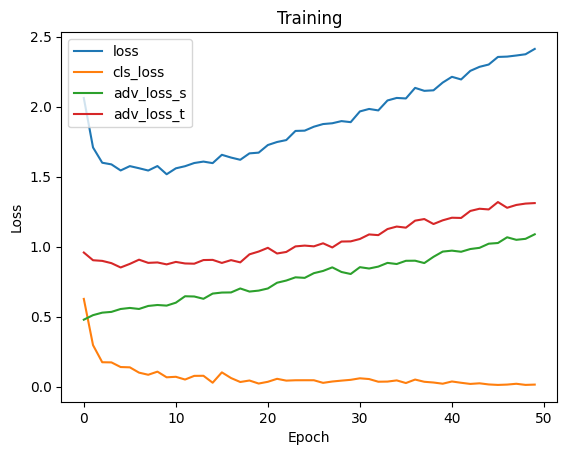

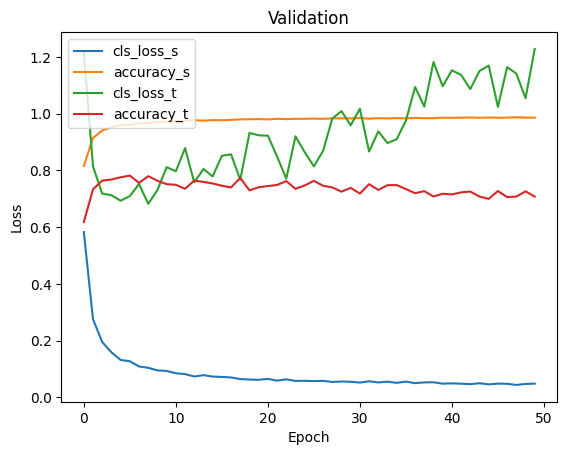

[0.07949236 0.97412    0.66133244 0.78953662]


In [14]:
np.save('all_loss_train.npy', all_loss_train)
np.save('all_loss_val.npy', all_loss_val)
np.save('all_loss_test.npy', all_loss_test)

plot_losses(
    list(np.mean(all_loss_train, axis=0).T),
    loss_labels_train,
    ylabel='Loss',
    xlabel='Epoch',
    title='Training'
)
plot_losses(
    list(np.mean(all_loss_val, axis=0).T),
    loss_labels_val,
    ylabel='Loss',
    xlabel='Epoch',
    title='Validation'
)
print(np.mean(all_loss_test, axis=0))